In [1]:
from data.soliton_dataset import SolitonDataset
from models.autoencoders import AutoencoderFC, AutoencoderConv1D, AutoencoderRNN
from utils.utils import train_val_test_split

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score as accuracy
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm

/home/olegnest/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
df = pd.read_csv("df_soliton.csv")
df.head()

,1550.0,1549.8748798925087,1549.7497799834402,1549.624700267904,1549.4996407410108,1549.3746013978732,1549.2495822336057,1549.1245832433235,1548.999604422144,1548.8746457651862,...,1551.1269907041835,1551.0016885905482,1550.8764067194222,1550.751145085901,1550.6259036850813,1550.5006825120613,1550.375481561941,1550.2503008298215,1550.1251403108065,target
0,25.646056,25.650028,25.639966,25.615890,25.577855,25.525948,25.460286,25.381017,25.288318,25.182399,...,24.990649,25.116764,25.230041,25.330229,25.417107,25.490478,25.550179,25.596074,25.628057,cons_one
1,106.806266,112.409808,424.880242,686.914489,1405.909674,32.762638,130.044831,625.502883,1410.410023,115.495991,...,325.588571,138.500308,80.540597,225.456932,649.640334,1.996701,229.406224,761.822174,213.996442,cons_many
2,66.742776,523.683413,317.596944,1046.224701,744.272499,250.673772,426.875556,270.139851,449.280882,289.328584,...,81.704307,349.552649,420.345688,186.359228,363.575276,56.096868,331.010606,199.400477,114.965091,cons_many
3,17.406022,17.368336,17.246741,17.043367,16.761907,16.407466,15.986371,15.505929,14.974164,14.399550,...,14.380802,14.948072,15.474983,15.953217,16.374769,16.732200,17.018902,17.229347,17.359305,cons_one
4,103.739823,103.581529,102.286535,99.899522,96.525690,92.330496,87.533321,82.394103,77.191973,72.194477,...,67.858970,73.340071,78.891431,84.296851,89.358338,93.893959,97.737289,100.739222,102.772649,cons_one


In [4]:
float_columns = sorted(df.columns[:-1])
cols = ["target"]
for col in float_columns:
    if 1520 < float(col) < 1580:
        cols.append(col)
df = df[cols]

In [5]:
df_train, df_val, df_test = train_val_test_split(df, 0.1, 0.1, random_state=SEED)

In [6]:
dim_int = df_train.shape[1] - 1

model = AutoencoderFC(dim_code=dim_int)
# model = AutoencoderConv1D(1)
# model = AutoencoderRNN(dim_int, 1)

In [7]:
if model.__class__.__name__ == "AutoencoderRNN":
    batch_size = 1
else:
    batch_size = 32
    
scaler = None 
# scaler = StandardScaler()
spectra_train = SolitonDataset(df_train, train=True, scaler=scaler)
spectra_val = SolitonDataset(df_val, scaler=scaler)
spectra_test = SolitonDataset(df_test, scaler=scaler)

train_dataloader = DataLoader(spectra_train,batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(spectra_val, batch_size=batch_size)
test_dataloader = DataLoader(spectra_test, batch_size=batch_size)

dataloaders = {"train": train_dataloader, "val": val_dataloader, "test": test_dataloader}

In [8]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adamax(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1)

In [9]:
def train(model, dataloaders, criterion, optimizer, num_epochs=10,
          scheduler=None, savename=None, device=torch.device("cpu")):
    
    model = model.to(device)
    losses_epoch = {'train': [], 'val': []}
    for epoch in tqdm(range(num_epochs)):
        loss_val = []
        loss_train = []

        model.train()
        for inputs, _, _, _ in dataloaders["train"]:
            inputs = inputs.to(device)
            optimizer.zero_grad()
            out, _ = model(inputs)
            loss = criterion(out, inputs)
            loss.backward()
            optimizer.step()
            loss_train.append(loss.detach().item())

        model.eval()
        for inputs, _, _, _ in dataloaders["val"]:
            inputs = inputs.to(device)
            out, _ = model(inputs)
            loss = criterion(out, inputs)
            loss_val.append(loss.detach().item())
        
        if scheduler:
            scheduler.step()

        train_loss_epoch = np.mean(loss_train)
        val_loss_epoch = np.mean(loss_val)
        losses_epoch["train"].append(train_loss_epoch)
        losses_epoch["val"].append(val_loss_epoch)

        print(f"Epoch #{epoch + 1}, train loss: {train_loss_epoch}, val loss: {val_loss_epoch}")

    if savename:
        torch.save(model.state_dict(), savename)
    
    return model, losses_epoch

In [10]:
model, fc_losses = train(model, dataloaders, criterion, optimizer, 10, scheduler, device=device)

 10%|█         | 1/10 [00:09<01:21,  9.01s/it]

Epoch #1, train loss: 5565.969584414834, val loss: 2518.362051571117


 20%|██        | 2/10 [00:17<01:11,  8.90s/it]

Epoch #2, train loss: 2681.3373575712503, val loss: 2433.2884880514707


 30%|███       | 3/10 [00:27<01:04,  9.28s/it]

Epoch #3, train loss: 2606.5571630377517, val loss: 2414.369348862592


 40%|████      | 4/10 [00:36<00:54,  9.13s/it]

Epoch #4, train loss: 2597.3053524619654, val loss: 2416.887729420381


 50%|█████     | 5/10 [00:46<00:47,  9.42s/it]

Epoch #5, train loss: 2596.7192194085374, val loss: 2416.623154584099


 60%|██████    | 6/10 [00:57<00:39,  9.95s/it]

Epoch #6, train loss: 2603.169716684442, val loss: 2416.6124231675094


 70%|███████   | 7/10 [01:08<00:30, 10.23s/it]

Epoch #7, train loss: 2601.3450225026986, val loss: 2416.608980066636


 80%|████████  | 8/10 [01:18<00:20, 10.20s/it]

Epoch #8, train loss: 2595.781987641987, val loss: 2416.6088741526883


 90%|█████████ | 9/10 [01:29<00:10, 10.43s/it]

Epoch #9, train loss: 2599.7598099959523, val loss: 2416.6088741526883


100%|██████████| 10/10 [01:40<00:00, 10.01s/it]

Epoch #10, train loss: 2596.6266856946445, val loss: 2416.6088741526883


In [11]:
reconst_sample, _, _, _ = next(iter(test_dataloader))
reconst_sample_cuda = reconst_sample.to(device)
reconst_out, _ = model(reconst_sample_cuda)
reconst_out = reconst_out.detach().numpy()
if scaler:
    reconst_sample = scaler.inverse_transform(reconst_sample)
    reconst_out = scaler.inverse_transform(reconst_out)

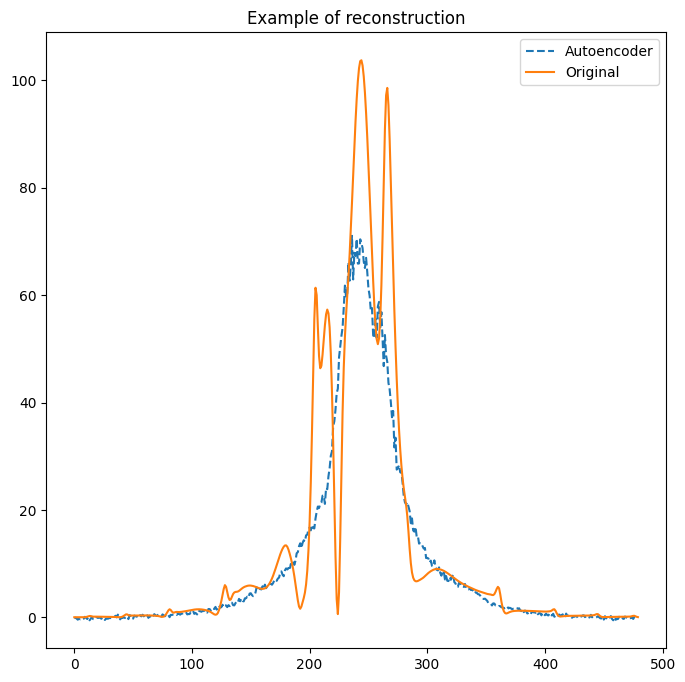

In [12]:
plt.figure(figsize=(8, 8))
plt.plot(reconst_out[0], label="Autoencoder", ls="--")
plt.plot(reconst_sample[0], label="Original")
plt.title("Example of reconstruction")
plt.legend();

In [13]:
def test(model, dataloaders, criterion, scaler=None, device=torch.device("cpu")):
    
      model = model.to(device)
      arr_emb_train = []
      arr_label_train = []
      arr_emb_test = []
      arr_label_test = []
      test_mse_loss = []

      model.eval()
      for anchor, _, _, anchor_label in dataloaders["train"]:
            anchor = anchor.to(device)

            _, anchor_out = model(anchor)
            arr_emb_train.append(anchor_out.detach().numpy())
            arr_label_train.append(anchor_label.detach().numpy())

      clf = KNeighborsClassifier(n_neighbors=3)
      emb_train = np.array(arr_emb_train[:-1]).reshape(-1,2)
      label_train = np.array(arr_label_train[:-1]).reshape(-1)
      clf.fit(X=emb_train, y=label_train)

      for anchor, _, _, anchor_label in dataloaders["test"]:
            anchor = anchor.to(device)
            anchor_rebuild, anchor_out = model(anchor)
            if scaler:
                  anchor = scaler.inverse_transform(anchor.detach().numpy())
                  anchor_rebuild = scaler.inverse_transform(anchor_rebuild.detach().numpy())
            loss_mse_test = criterion(torch.tensor(anchor), torch.tensor(anchor_rebuild))
            test_mse_loss.append(loss_mse_test.item())
            arr_emb_test.append(anchor_out.cpu().detach().numpy())
            arr_label_test.append(anchor_label.cpu().detach().numpy())

      emb_test = np.array(arr_emb_test[:-1]).reshape(-1,2)
      label_test = np.array(arr_label_test[:-1]).reshape(-1)
      label_pred = clf.predict(X=emb_test)
      acc = accuracy(label_test, label_pred)
      silhoutte = silhouette_score(X=emb_test, labels=label_test)
      return acc, silhoutte, test_mse_loss

In [14]:
acc, silhoutte, test_mse_loss = test(model, dataloaders, criterion, scaler=scaler, device=device)

/tmp/ipykernel_110830/275767823.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_mse_test = criterion(torch.tensor(anchor), torch.tensor(anchor_rebuild))


In [15]:
print(f"Classifier accuracy: {acc}\nSilhoutter score: {silhoutte}\nMSE: {np.mean(test_mse_loss)}")

Classifier accuracy: 0.8454861111111112
Silhoutter score: -0.1105256974697113
MSE: 2035.5596918808787


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 37.36it/s]


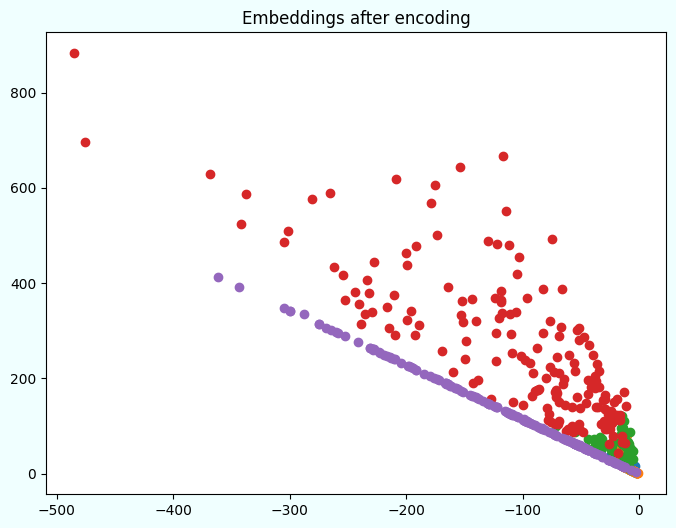

In [16]:
train_results = []
labels = []

model.eval()
for anchor, _, _, anchor_laber in tqdm(dataloaders["test"]):
    _,emb = model(anchor.to(device))
    train_results.append(emb.detach().numpy())
    labels.append(anchor_laber)

train_results = np.concatenate(train_results)
labels = np.concatenate(labels)
plt.figure(figsize=(8, 6), facecolor="azure")
for label in np.unique(labels):
    tmp = train_results[labels==label]
    plt.scatter(tmp[:, 0], tmp[:, 1])
plt.title("Embeddings after encoding");